In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax
import interpax as ipx


# dLux imports
import dLux as dl
import dLux.utils as dlu


# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from newfisher import *
from stats import posterior
from fitting import *
from plotting import *

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 32
oversample = 4

nwavels = 8#20
npoly=nwavels

nzernikes = 12

optics = NICMOSOptics(512, wid, oversample, n_zernikes=nzernikes)

detector = NICMOSDetector(oversample, wid)

In [4]:
exposures = [
    BlankExposure("test", "F110W", SinglePointSpectrumFit(nwavels))
] 

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_11943/4173703465.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  BlankExposure("test", "F110W", SinglePointSpectrumFit(nwavels))


In [5]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = 3.45

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    
    """np.asarray([1.6117526, 1.630006 , 1.7464325, 1.7394772, 1.8483782, 1.9626302,
         2.0166223, 2.054695 , 2.1089914, 2.2015576, 2.2763495, 2.3084195,
         2.2964146, 2.3258219, 2.3839521, 2.354199 , 2.3219314, 2.3110254,
         2.3895059, 2.0729065])#np.asarray([1.,0.,1.,0.,1.,0.,1.,0.,1.])+1#jr.uniform(jr.key(1), (nwavels,), minval=-1, maxval=1)#.at[0].set(1)"""

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(nzernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.08, -0.08])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

injected_model = set_array(NICMOSModel(exposures, params, optics, detector))

injected_params = ModelParams(params)

In [6]:
exposures = [
    #InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e-3, 10)
    InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e10, 10)
]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_11943/686238235.py:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e10, 10)


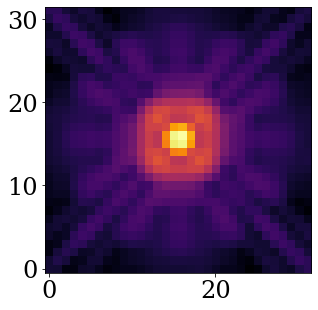

In [7]:
plt.imshow(exposures[0].data**0.125)

In [8]:
@eqx.filter_jit
def interp(image, knot_coords, sample_coords, method="linear", fill=0.0):
    xs, ys = knot_coords
    xpts, ypts = sample_coords.reshape(2, -1)

    return ipx.interp2d(ypts, xpts, ys[:, 0], xs[0], image, method=method, extrap=fill).reshape(
        sample_coords[0].shape
    )
    

In [9]:
import equinox as eqx
import dLux.utils as dlu
from jax import vmap

def fft_coords(wl, npix, pscale, pad=2):
    x = np.fft.fftshift(np.fft.fftfreq(pad * npix, d=pscale / wl))
    return np.array(np.meshgrid(x, x))


def wf_fft_coords(wfs, pad=2):
    wls = wfs.wavelength
    psf_pscale = wfs.pixel_scale[0]
    psf_npix = wfs.npixels
    return vmap(lambda wl: fft_coords(wl, psf_npix, psf_pscale, pad=pad))(wls)


def vis_to_im(amps, phases, shape):
    # Conjugate the amplitudes and phases
    amp = 1.0 + np.concatenate([amps, np.array([0.0]), amps[::-1]], axis=0)
    phase = np.concatenate([phases, np.array([0.0]), -phases[::-1]], axis=0)
    return amp.reshape(shape), phase.reshape(shape)


def inject_vis(psfs, amps, phases, otf_coords, uv_coords):
    # Get the amplitudes and phases
    amp, phase = vis_to_im(amps, phases, otf_coords.shape[1:])

    # Build the visibility maps
    interp_fn = lambda im, uv, fill: interp(
        im, otf_coords, uv, method="linear", fill=fill
    )
    amps = vmap(lambda uv: interp_fn(amp, uv, fill=1.0))(uv_coords)
    phases = vmap(lambda uv: interp_fn(phase, uv, fill=0.0))(uv_coords)
    cplx = amps * np.exp(1j * phases)

    # Fourier Functions
    n = uv_coords.shape[-1] // 4
    pad_fn = lambda x: np.pad(x, n, mode="constant")
    crop_fn = lambda x: x[n:-n, n:-n]
    to_uv = vmap(lambda x: np.fft.fftshift(np.fft.fft2(pad_fn(x))))
    from_uv = vmap(lambda x: crop_fn(np.fft.ifft2(np.fft.ifftshift(x))))

    # Apply the visibility maps
    splodges = to_uv(psfs)
    applied = cplx * splodges
    return np.abs(from_uv(applied)).sum(0)

def model_vis_psf(optics, amp, phase, filter, aberrations, defocus, n_knots=51):
    #
    #optics = optics.set(
    #    ["pupil_mask.abb_coeffs", "defocus"],
    #    [aberrations, defocus],
    #)

    #
    wavels, weights = calc_throughput(filter, nwavels=nwavels)
    wfs = eqx.filter_jit(optics.propagate)(wavels, weights=weights, return_wf=True)

    #
    otf_coords = dlu.pixel_coords(n_knots, 2 * optics.diameter)
    uv_coords = wf_fft_coords(wfs, pad=2)
    return inject_vis(wfs.psf, amp, phase, otf_coords, uv_coords)

In [10]:
from jax.flatten_util import ravel_pytree


def batched_jacobian(X, fn, n_batch=1):
    Xs = np.array_split(X, n_batch)
    rebuild = lambda X_batch, index: X.at[index : index + len(X_batch)].set(X_batch)
    lens = np.cumsum(np.array([len(x) for x in Xs]))[:-1]
    starts = np.concatenate([np.array([0]), lens])

    @eqx.filter_jacfwd
    def batched_jac_fn(x, index):
        return eqx.filter_jit(fn)(rebuild(x, index))

    return np.concatenate(
        [batched_jac_fn(x, index) for x, index in zip(Xs, starts)], axis=-1
    ).T


def decompose(J, values):
    # Get the covariance matrix
    cov = np.eye(values.size) * values[..., None]

    # Get the hessian
    hess = J @ (cov @ J.T)

    # Get the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(hess)
    eigvecs, eigvals = np.real(eigvecs).T, np.real(eigvals)

    #
    eigvals /= eigvals[0]
    return hess, eigvals, eigvecs

In [11]:
aberrations = optics.get("AberratedAperture.coefficients")

In [12]:
exp = exposures[0]
optics = exp.fit.update_optics(injected_model, exp)
optics.get("cold_mask.transformation.translation")

Array([0.08, 0.08], dtype=float32)

In [13]:
filters = ["F110W"]

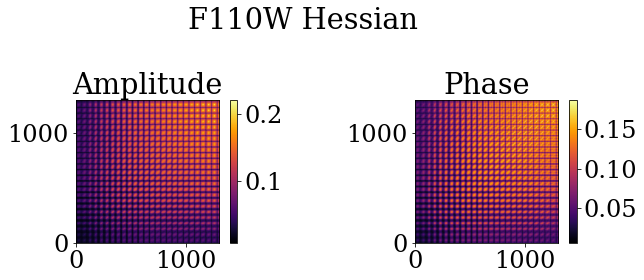

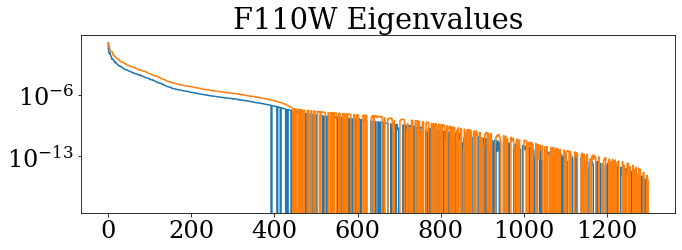

In [14]:
n_terms = 250
eig_mats = {"amplitude": {}, "phase": {}}
for filt in ["F110W",]:
    n_knots = 51
    n_pts = (n_knots**2) // 2
    amp, phase = np.zeros((2, n_pts))
    abb = None#aberrations[filt]
    defoc = None#defocus[filt]

    # aberrations = np.zeros_like(abb_coeffs[filt])
    # defocus = np.zeros_like(state["defocus"][filt])

    output_fn = lambda x: dlu.downsample(x, oversample, mean=False).flatten()
    vis_fn = lambda amp, phase: output_fn(
        model_vis_psf(optics, amp, phase, filt, abb, defoc, n_knots)
    )
    J_amp = batched_jacobian(amp, lambda X: vis_fn(X, phase), n_batch=10)
    J_phase = batched_jacobian(phase, lambda X: vis_fn(amp, X), n_batch=10)

    psf = vis_fn(amp, phase)
    H_amp, amp_vals, amp_vecs = decompose(J_amp, psf)
    H_phase, phase_vals, phase_vecs = decompose(J_phase, psf)
    eig_mats['amplitude'][filt] = amp_vecs
    eig_mats['phase'][filt] = phase_vecs

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{filt} Hessian")

    plt.subplot(1, 2, 1)
    plt.title("Amplitude")
    plt.imshow(np.abs(H_amp) ** 0.1, cmap="inferno")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Phase")
    plt.imshow(np.abs(H_phase) ** 0.1, cmap="inferno")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title(f"{filt} Eigenvalues")
    plt.plot(amp_vals[:], label="Amplitude")
    plt.plot(phase_vals[:], label="Phase")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

In [15]:
n_modes = 180

In [16]:
inferno = matplotlib.colormaps["inferno"]
seismic = matplotlib.colormaps["seismic"]
coolwarm = matplotlib.colormaps["coolwarm"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)

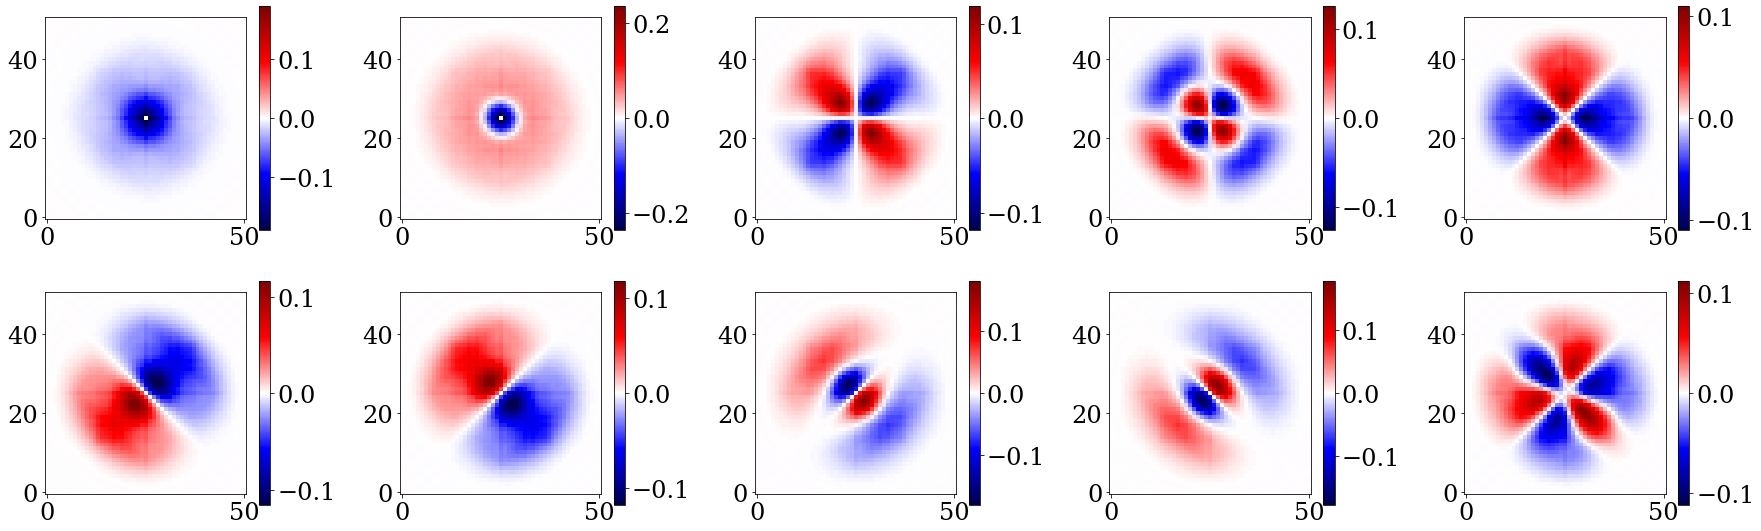

In [17]:
off = 0
plt.figure(figsize=(25, 8))
for i in range(5):
    amp, phase = vis_to_im(amp_vecs[i+off], phase_vecs[i+off], (51, 51))
    amp = amp - 1

    v = np.nanmax(np.abs(amp))
    plt.subplot(2, 5, i + 1)
    plt.imshow(amp, seismic, vmin=-v, vmax=v)
    plt.colorbar()

    v = np.nanmax(np.abs(phase))
    plt.subplot(2, 5, i + 6)
    plt.imshow(phase, seismic, vmin=-v, vmax=v)
    plt.colorbar()

plt.tight_layout()
plt.show()

In [18]:
otf_coords = dlu.pixel_coords(51, 2 * optics.diameter)
basis_dict = {
    "eigen_vectors": eig_mats,
    "otf_coords": otf_coords,
}

In [19]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "phases":{},
    "amplitudes":{},
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = 3.45

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    
    """np.asarray([1.6117526, 1.630006 , 1.7464325, 1.7394772, 1.8483782, 1.9626302,
         2.0166223, 2.054695 , 2.1089914, 2.2015576, 2.2763495, 2.3084195,
         2.2964146, 2.3258219, 2.3839521, 2.354199 , 2.3219314, 2.3110254,
         2.3895059, 2.0729065])#np.asarray([1.,0.,1.,0.,1.,0.,1.,0.,1.])+1#jr.uniform(jr.key(1), (nwavels,), minval=-1, maxval=1)#.at[0].set(1)"""

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(nzernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.2, 8.2])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["phases"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_modes)
    params["amplitudes"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_modes)




injected_model = set_array(NICMOSModel(exposures, params, optics, detector))

injected_params = ModelParams(params)

In [20]:
params

{'fluxes': {'test_F110W': 3.45},
 'positions': {'test_F110W': Array([0., 0.], dtype=float32)},
 'spectrum': {'test_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)},
 'aberrations': {'test_F110W': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)},
 'cold_mask_shift': {'0': Array([8.2, 8.2], dtype=float32)},
 'cold_mask_rot': {'global': -45.0},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'outer_radius': 1.146,
 'secondary_radius': 0.44639999999999996,
 'spider_width': 0.0924,
 'scale': 0.0432,
 'rot': 0.0,
 'softening': 2.0,
 'phases': {'test_F110W': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 

In [21]:
injected_params.get(exp.fit.map_param(exp, "cold_mask_shift"))

Array([8.2, 8.2], dtype=float32)

In [22]:
vis_model = LogVisModel(basis_dict, n_basis=n_modes)

In [23]:
exposures = [
    #InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e-3, 10)
    InjectedExposure("test", 'F110W', SpectrumVisFit(nwavels, vis_model), injected_model, 287*1e0, 10)
]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_11943/3715573636.py:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  InjectedExposure("test", 'F110W', SpectrumVisFit(nwavels, vis_model), injected_model, 287*1e0, 10)


phases.test_F110W


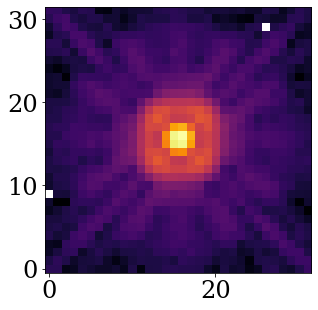

In [24]:
plt.imshow(exposures[0].data**0.125)

In [25]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "phases":{},
    "amplitudes":{},
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = 3.45

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    
    """np.asarray([1.6117526, 1.630006 , 1.7464325, 1.7394772, 1.8483782, 1.9626302,
         2.0166223, 2.054695 , 2.1089914, 2.2015576, 2.2763495, 2.3084195,
         2.2964146, 2.3258219, 2.3839521, 2.354199 , 2.3219314, 2.3110254,
         2.3895059, 2.0729065])#np.asarray([1.,0.,1.,0.,1.,0.,1.,0.,1.])+1#jr.uniform(jr.key(1), (nwavels,), minval=-1, maxval=1)#.at[0].set(1)"""

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(nzernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.0, 8.0])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["phases"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_modes)
    params["amplitudes"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_modes)




model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [26]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_rmsprop = lambda vals: optax.rmsprop(vals)#, nesterov=True, momentum=0.6)
optr = lambda lr, start, *schedule: base_rmsprop(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 1e-2

things = {
    "phases": opt(g, 0),
    "amplitudes": opt(g, 0),#, (20, 1.5)),
}


groups = list(things.keys())

In [27]:
losses, models = optimise(params, model, exposures, things, 1000, reduce_ram=True)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

phases.test_F110W
phases.test_F110W
ModelParams(
  params={
    'fluxes': {'test_F110W': 3.45},
    'positions': {'test_F110W': f32[2]},
    'spectrum': {'test_F110W': f32[8]},
    'aberrations': {'test_F110W': f32[12]},
    'cold_mask_shift': {'0': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F110W': f32[2]},
    'cold_mask_shear': {'F110W': f32[2]},
    'primary_scale': {'F110W': f32[2]},
    'primary_rot': {'F110W': -45.0},
    'primary_shear': {'F110W': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.0432,
    'rot': 0.0,
    'softening': 2.0,
    'phases': {'test_F110W': f32[180]},
    'amplitudes': {'test_F110W': f32[180]}
  }
)
Fitting Model


  0%|          | 0/1000 [00:00<?, ?it/s]

phases.test_F110W


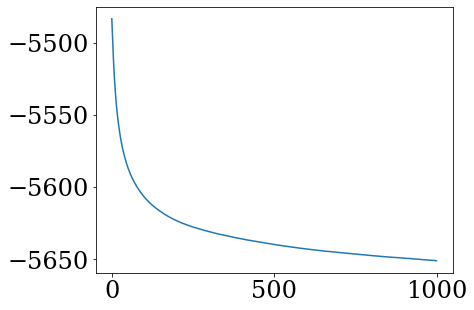

In [28]:
plt.plot(losses[:])

In [29]:
losses[-1]

Array(-5651.093, dtype=float32)

phases.test_F110W
phases.test_F110W


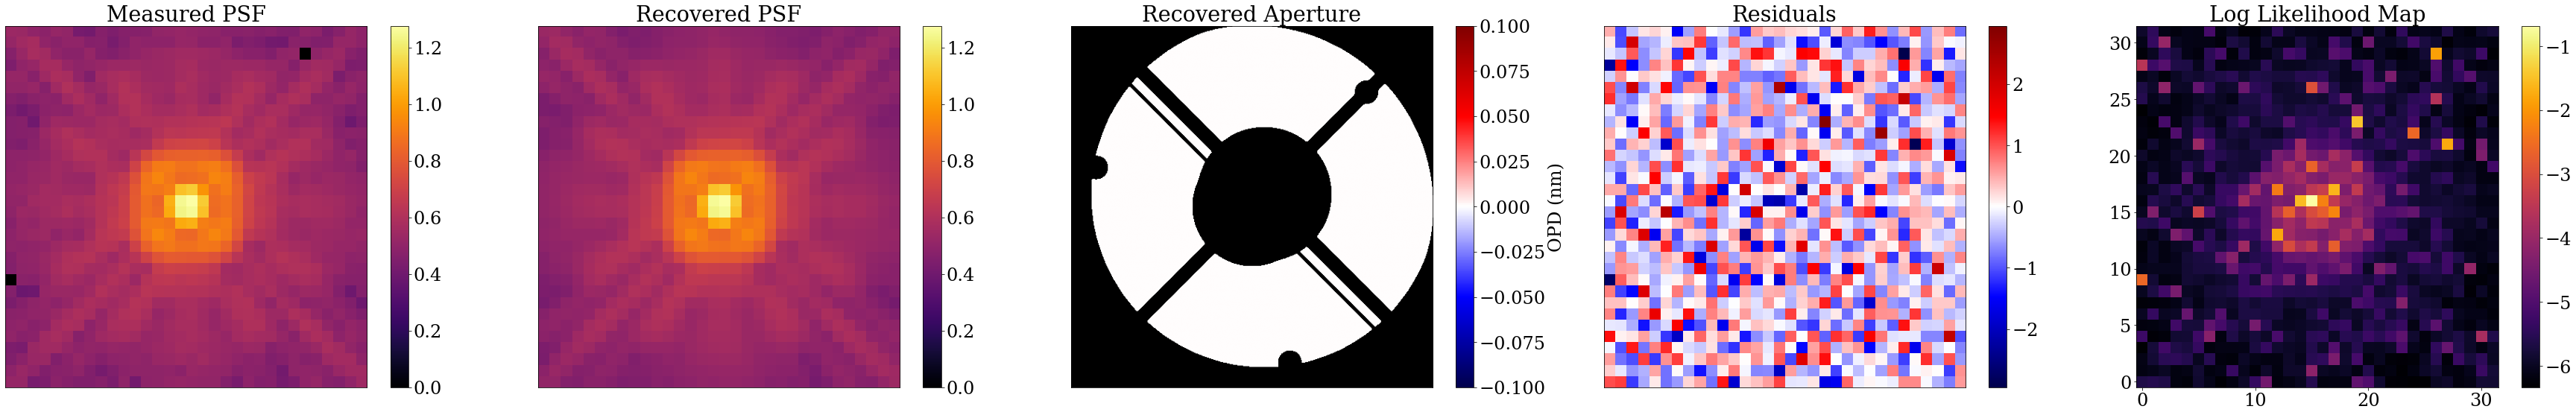

In [30]:
plot_comparison(model, models[-1], exposures)

In [31]:
models[-1].params

{'amplitudes': {'test_F110W': Array([ 2.63717007e-02, -1.46970740e-02,  6.64993469e-03, -7.32889958e-03,
         -1.76101718e-02,  9.75359790e-03,  3.72545770e-03,  9.15920828e-05,
         -6.69138134e-03, -2.34039733e-03,  1.01656662e-02,  1.58025343e-02,
          9.41523910e-03, -5.16249239e-03, -4.30346560e-03, -8.34504049e-03,
         -7.28703337e-03,  7.90115073e-03, -1.08250545e-03, -4.09099692e-03,
         -6.99487096e-03,  1.71012734e-03, -1.02769700e-03, -1.01226801e-03,
         -4.96793166e-03,  2.96690923e-05, -2.76815682e-03,  4.32320265e-03,
         -5.89444395e-03, -6.57207565e-05, -8.11435934e-03, -2.77190760e-04,
          4.30417899e-03, -2.32497766e-03, -7.07414746e-03, -1.28399511e-03,
          6.00425119e-05,  4.90035489e-03, -1.85006822e-03, -4.14544344e-03,
         -5.30038145e-04,  8.20344128e-03, -2.01503839e-03,  2.64930981e-03,
          4.92837629e-04,  5.06609073e-03,  1.64186419e-03,  6.84048235e-03,
          8.40288959e-03,  2.81211175e-03, -4.81

In [32]:
fmats = {}
for exp in tqdm(exposures):
    params = [exp.map_param("amplitudes"), exp.map_param("phases")]
    fmat = FIM(models[-1].inject(model), params, posterior, exp, reduce_ram=True, batch_size=20)
    fmats[exp.get_key("phases")] = fmat

  0%|          | 0/1 [00:00<?, ?it/s]

phases.test_F110W


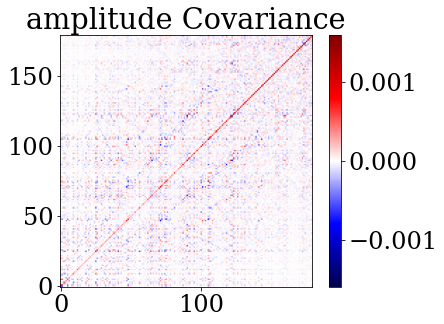

In [33]:
full_covs = jax.tree.map(lambda x: np.linalg.inv(x), fmats)

n = vis_model.n_basis
amp_covs = jax.tree.map(lambda x: x[:n, :n], full_covs)
phase_covs = jax.tree.map(lambda x: x[n:, n:], full_covs)

covs = {
    "amplitudes": amp_covs,
    "phases": phase_covs,
}

plt.figure(figsize=(20, 10))
for i, key in enumerate(amp_covs):
    if i > 5:
        break

    if i < 3:
        param = "amplitude"
        cov = amp_covs[key]
    else:
        param = "phase"
        cov = amp_covs[key]
    plt.subplot(2, 3, i + 1)
    plt.title(f"{param} Covariance")
    v = np.nanmax(np.abs(cov))
    plt.imshow(cov, seismic, vmin=-v, vmax=v)
    # plt.imshow(np.log10(np.abs(cov)), inferno)
    plt.colorbar()
plt.show()

In [34]:
from vis_models import vis_jac_fn

def svd(jacobian, normalise=True):
    u, s, vh = np.linalg.svd(jacobian, full_matrices=True)
    if normalise:
        s /= s[0]
    return u, s, vh


thresh = 1e-5
kernel_outputs = {}
for filt in tqdm(["F110W",]):

    model_params = ModelParams(
        {
            # Note we dont need to marginalise over positions - its subsumed by abbs
            #"spectra": np.zeros(1),
            #"fluxes": np.zeros(1),
            "spectrum": 10**np.ones(nwavels),
            "aberrations": np.zeros(12),#aberrations,#*1e-9,
            "cold_mask_shift": np.asarray([8.0,8.0]),
            "positions": np.zeros(2),
        }
    )

    jac_fn = lambda X: vis_jac_fn(X, (optics, vis_model, filt))
    amp_fn, phase_fn = lambda X: jac_fn(X)[0], lambda X: jac_fn(X)[1]
    J_amp = model_params.jacfwd(amp_fn, n_batch=30)
    J_phase = model_params.jacfwd(phase_fn, n_batch=30)

    # Get the Jacobian decompositions
    u_amp, s_amp, vh_amp = svd(J_amp)
    u_phase, s_phase, vh_phase = svd(J_phase)

    n_amp = len(s_amp) - np.sum(s_amp < thresh)
    n_phase = len(s_phase) - np.sum(s_phase < thresh)

    kernel_outputs[filt] = {
        "kernel_mats": {
            "amplitudes": u_amp[:, n_amp:].T,
            "phases": u_phase[:, n_phase:].T,
        },
        "proj_mats": {
            "amplitudes": u_amp[:, :len(s_amp)].T,
            "phases": u_phase[:, :len(s_phase)].T,
        },
        "J_mats": {
            "amplitudes": J_amp,
            "phases": J_phase,
        },
        "singular_vals": {
            "amplitudes": s_amp,
            "phases": s_phase,
        },
    }


  0%|          | 0/1 [00:00<?, ?it/s]

starting
spectrum
starting
spectrum


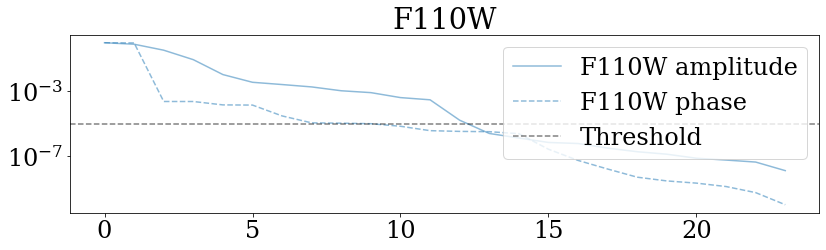

In [35]:
plt.figure(figsize=(12, 4))
for i, filt in enumerate(["F110W"]):
    s_amp = kernel_outputs[filt]["singular_vals"]["amplitudes"]
    s_phase = kernel_outputs[filt]["singular_vals"]["phases"]

    plt.title(filt)
    plt.plot(s_amp, label=f"{filt} amplitude", c=f"C{i}", alpha=0.5)
    plt.plot(s_phase, label=f"{filt} phase", ls="--", c=f"C{i}", alpha=0.5)
    plt.yscale("log")

plt.axhline(thresh, ls="--", c="k", alpha=0.5, label="Threshold")
plt.legend()
plt.tight_layout()
plt.show()

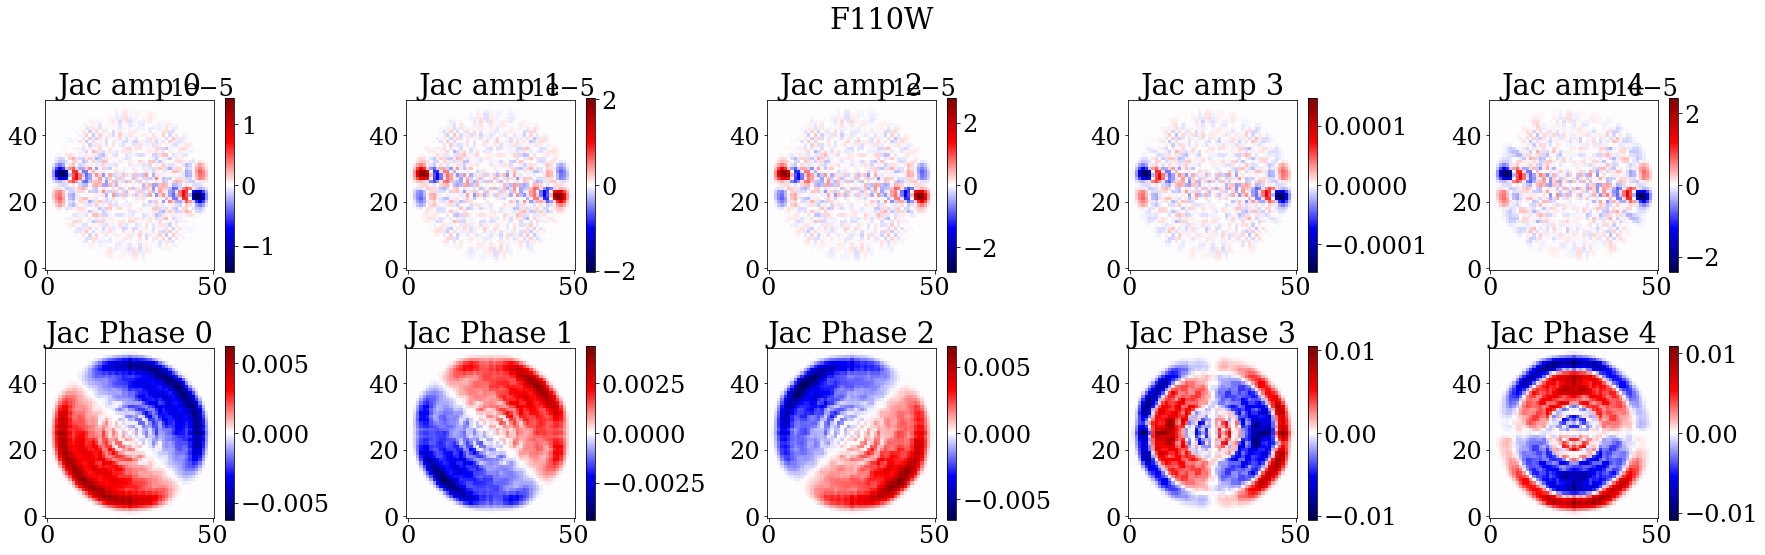

In [36]:
for filt in filters:
    lat_amp_Js = kernel_outputs[filt]["J_mats"]["amplitudes"]
    lat_phase_Js = kernel_outputs[filt]["J_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    plt.suptitle(filt)
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(lat_amp_Js[:, i], lat_phase_Js[:, i], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"Jac amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"Jac Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

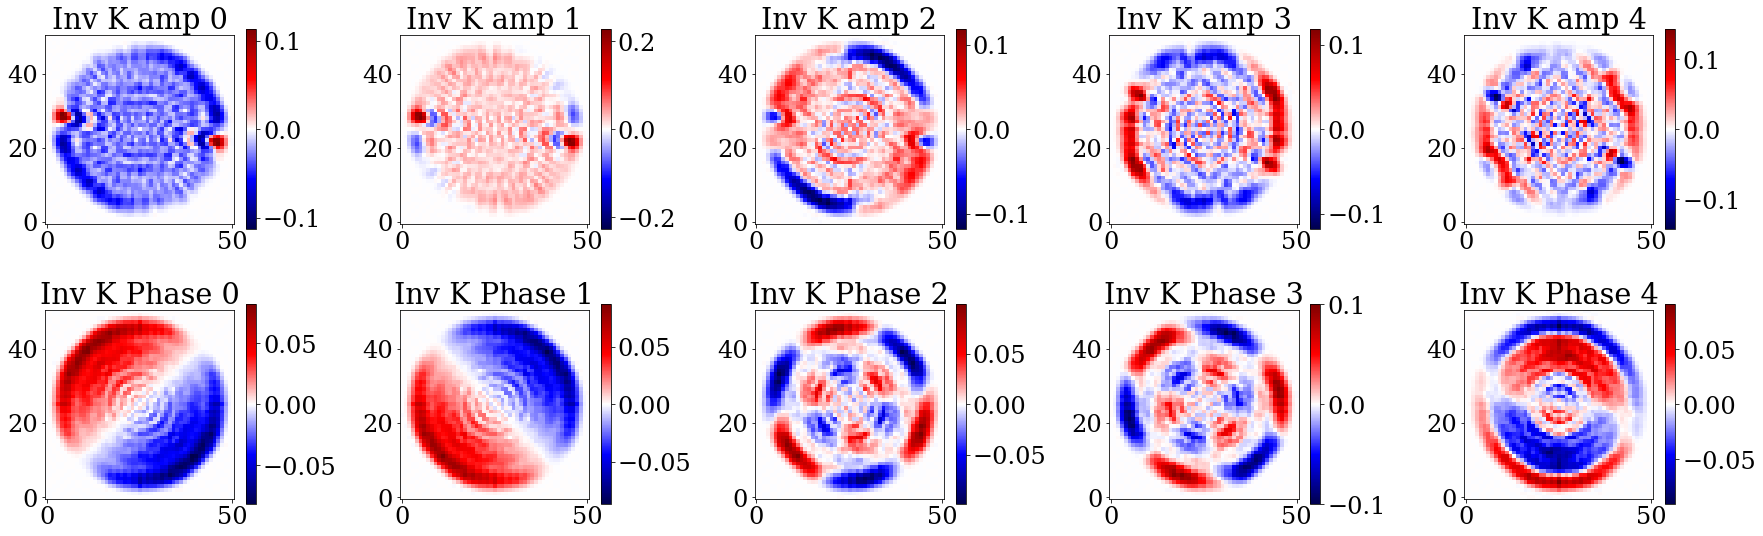

In [37]:
for filt in filters:
    amp_vecs = kernel_outputs[filt]["proj_mats"]["amplitudes"]
    phase_vecs = kernel_outputs[filt]["proj_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(amp_vecs[i], phase_vecs[i], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"Inv K amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"Inv K Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

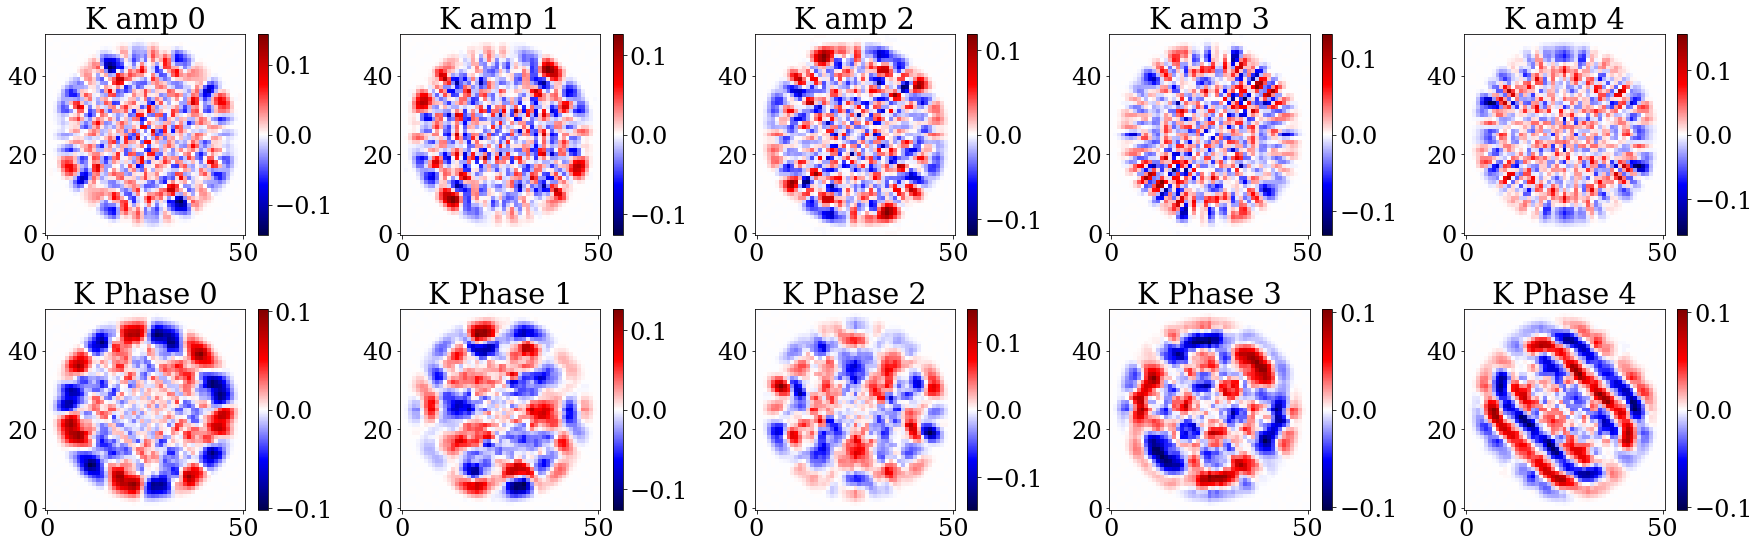

In [38]:
for filt in filters:

    amp_vecs = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
    phase_vecs = kernel_outputs[filt]["kernel_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(amp_vecs[i+0], phase_vecs[i+0], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"K amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"K Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

In [39]:
fmats["test_F110W"]

Array([[ 2.7795988e+04,  4.3916336e+04,  3.7400076e+03, ...,
         3.7166492e+02, -2.8453819e+01,  2.3608289e+02],
       [ 4.3916348e+04,  9.4239555e+04,  1.8043435e+03, ...,
         6.3536023e+02,  1.6060623e+02,  3.4388660e+02],
       [ 3.7400071e+03,  1.8043414e+03,  4.2576461e+04, ...,
        -9.0797707e+01, -5.5556702e+01,  1.8073111e+02],
       ...,
       [ 3.7166425e+02,  6.3536072e+02, -9.0797974e+01, ...,
         6.3478936e+03, -9.0900934e+02,  7.1569714e+02],
       [-2.8453493e+01,  1.6060596e+02, -5.5556656e+01, ...,
        -9.0900922e+02,  4.7419717e+03, -2.9949554e+02],
       [ 2.3608281e+02,  3.4388623e+02,  1.8073126e+02, ...,
         7.1569702e+02, -2.9949585e+02,  5.1316484e+03]], dtype=float32)

In [40]:
from stats import orthogonalise
from vis_calibration import get_mean_wavelength, average_vis_fits, calibrate_vis

filt = "F110W"

vals = {}

vals["fishers"] = fmats["test_F110W"]

vals["amplitudes"] = models[-1].get("amplitudes.test_F110W")
vals["phases"] = models[-1].get("phases.test_F110W")

n_basis = vis_model.n_basis

amp_K = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
phase_K = kernel_outputs[filt]["kernel_mats"]["phases"]



full_cov = np.linalg.inv(vals["fishers"])
amp_cov = full_cov[:n_basis, :n_basis]
phase_cov = full_cov[n_basis:, n_basis:]

vals["amp_cov"] = amp_cov
vals["phase_cov"] = phase_cov
vals["K_amp"] = np.dot(amp_K, vals["amplitudes"])
vals["K_phase"] = np.dot(phase_K, vals["phases"])
vals["K_amp_cov"] = np.dot(amp_K, np.dot(amp_cov, np.linalg.pinv(amp_K)))
vals["K_phase_cov"] = np.dot(phase_K, np.dot(phase_cov, np.linalg.pinv(phase_K)))

# Get the spectrally weighted wavelengths
wavels, filt_weights = calc_throughput(filt, nwavels=nwavels)
vals["wavel"] = get_mean_wavelength(wavels, filt_weights, np.ones(nwavels))


k_cal_vis_dict =  {
        f"K_vis": vals["K_amp"],
        f"K_vis_cov": vals["K_amp_cov"],
        f"K_phi": vals["K_phase"],
        f"K_phi_cov": vals["K_phase_cov"],
    }

# Projection matrices
V_amp = vis_model.V_amp[filt]
V_phase = vis_model.V_phase[filt]
K_amp_op = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
K_phase_op = kernel_outputs[filt]["kernel_mats"]["phases"]

# Orthonormalise the visibilities
K_vis = k_cal_vis_dict["K_vis"]
K_phi = k_cal_vis_dict["K_phi"]
K_vis_cov = k_cal_vis_dict["K_vis_cov"]
K_phi_cov = k_cal_vis_dict["K_phi_cov"]
o_vis, o_vis_cov, o_vis_mat, _ = orthogonalise(K_vis, K_vis_cov)
o_phi, o_phi_cov, o_phi_mat, _ = orthogonalise(K_phi, K_phi_cov)

# Save the Orthonormal calibrated Kernel Observables (Ockos)
o_cal_vis_dict = {
    "O_vis": o_vis,
    "O_phi": o_phi,
    "O_vis_cov": o_vis_cov,
    "O_phi_cov": o_phi_cov,
    "O_vis_mat": o_vis_mat,
    "O_phi_mat": o_phi_mat,
}

# uv coordinates
parang = 0.#vis_outputs[sci_key]["parangs"].mean(0)
wavel = vals["wavel"]

# Get the coordinates
n = vis_model.n_knots**2 // 2
u, v = vis_model.otf_coords.reshape(2, -1)[:, :n]
u, v = dlu.rotate_coords(np.array([u, -v]), -dlu.deg2rad(parang))

sci_outputs = {
    "u": u,
    "v": v,
    "vis_mat": V_amp,
    "phi_mat": V_phase,
    "K_vis_mat": K_amp_op,
    "K_phi_mat": K_phase_op,
    "parang": parang,
    "wavel": wavel,
}

cal_vis_dict = {**sci_outputs, **o_cal_vis_dict, **k_cal_vis_dict}


In [41]:
from vis_analysis import analyse_vis, AmigoOIData

output = analyse_vis(
    AmigoOIData(cal_vis_dict),
    size=650,  # mas
    n_pts=60,  # number of points in the final grid
    n_grid=60,  # number of initial grid points
    n_batch=10,  # number of batches to calculate the likelihood
    min_flux=-6,  # minimum log flux range
    tol=1e-8,  # tolerance for the optimizer (linear OR log space)
    max_steps=512,  # maximum number of steps for the optimizer
    n_sigma=3.0,  # number of sigma for the upper limits
    log=False,
)

In [42]:
output

{'oi_obj': AmigoOIData(
   u=f32[1300],
   v=f32[1300],
   wavel=f32[],
   parang=f32[],
   vis=f32[167],
   d_vis=f32[167],
   phi=f32[170],
   d_phi=f32[170],
   vis_mat=f32[1300,167],
   phi_mat=f32[1300,170]
 ),
 'fov': (Array(37.58542, dtype=float32), Array(2657.6917, dtype=float32)),
 'extent': (Array(650., dtype=float32),
  Array(-650., dtype=float32),
  Array(-650., dtype=float32),
  Array(650., dtype=float32)),
 'loglike_im': Array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'contrast_im': Array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [

[Text(0.5, 1.0, 'Broadband Log-Likelihood'),
 Text(0.5, 0, '$\\Delta$RA [mas]'),
 Text(0, 0.5, '$\\Delta$DEC [mas]')]

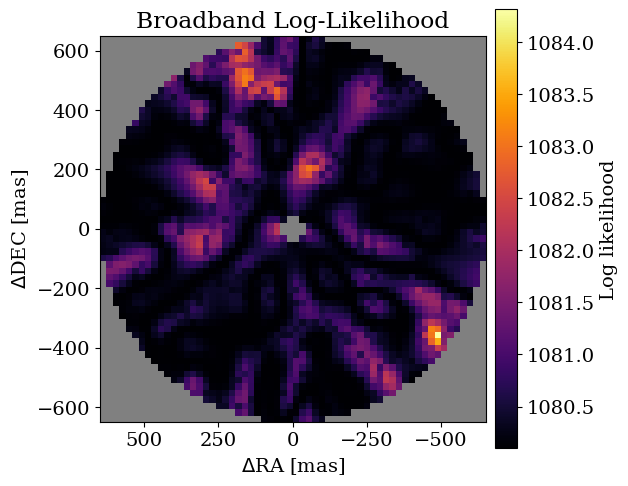

In [43]:
bb_loglike = output["loglike_im"]
extent = output["extent"]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
im = ax.imshow(bb_loglike, cmap=inferno, aspect="equal", extent=extent)
fig.colorbar(im, ax=ax, shrink=0.95, label="Log likelihood", pad=0.02)
ax.set(
    title="Broadband Log-Likelihood",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)

In [44]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

make_circle = lambda position, diameter, **kwargs: mpl.patches.Circle(
    position, diameter / 2, color="w", fill=False, linewidth=2, **kwargs
)



In [45]:
inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]
inferno_r = mpl.colormaps["inferno_r"]
inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)
inferno_r.set_bad("k", 0.5)

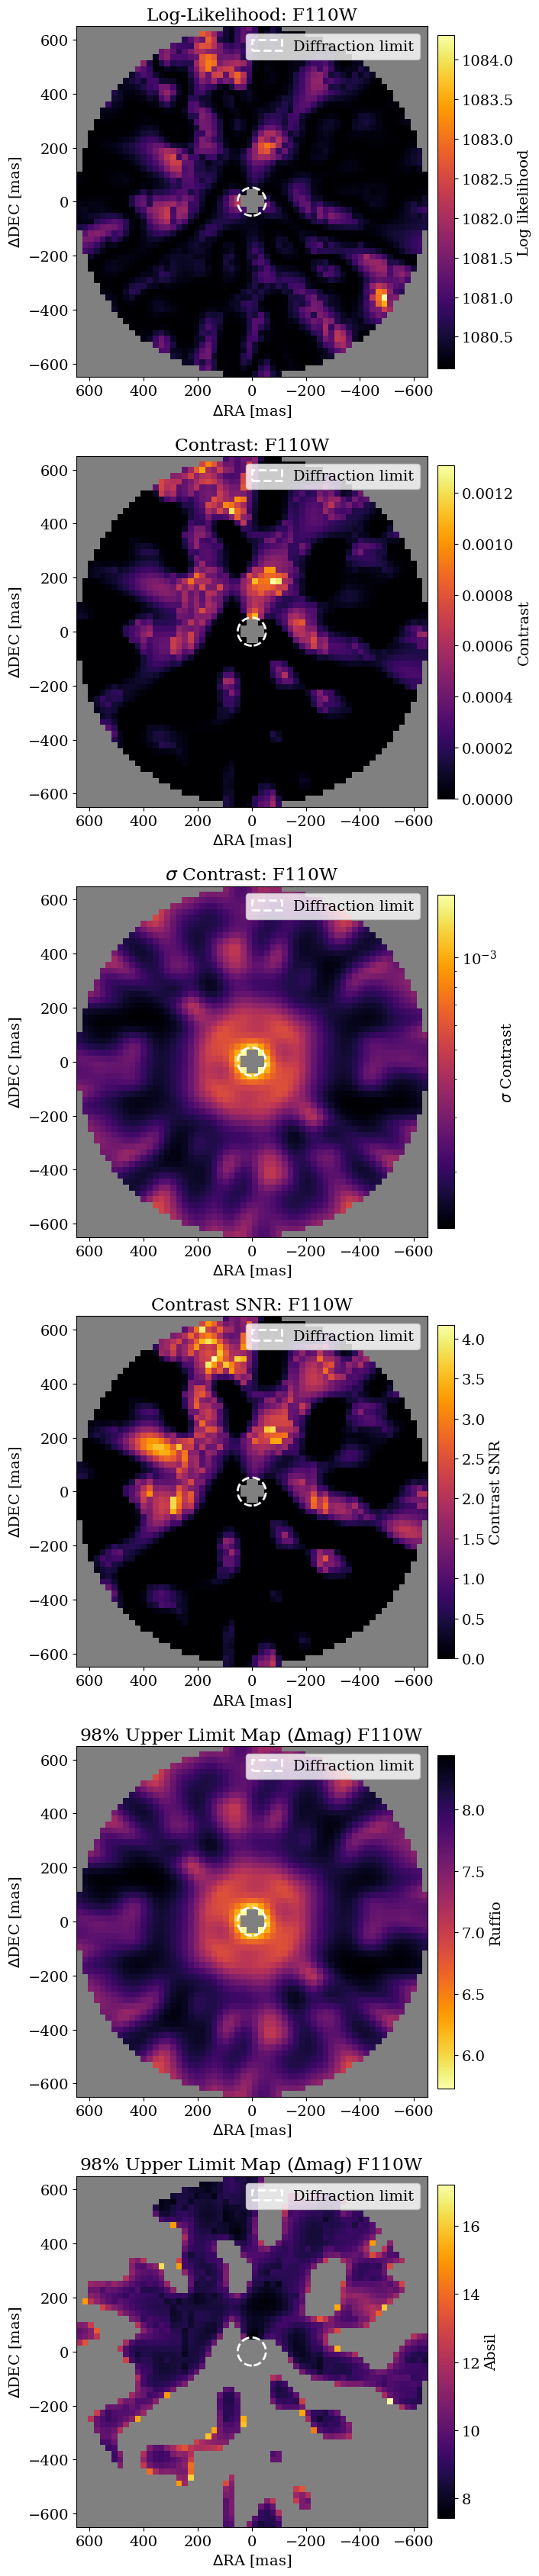

In [46]:
plt.figure(figsize=(22, 34))
loglike_im = output["loglike_im"]
contrast_im = output["contrast_im"]
sigma_im = output["sigma_im"]
ruffio_im = output["ruffio_im"]
limits_im = output["limits_im"]
min_fov, max_fov = output["fov"]
extent = output["extent"]
wavel = output["oi_obj"].wavel

diff_lim = 1e3 * dlu.rad2arcsec(wavel / 2.4)

i = 0

def add_to_ax(ax):
    #[ax.add_patch(make_circle(binary, 2 * min_fov)) for binary in binaries]
    ax.add_patch(make_circle((0, 0), diff_lim, ls="--", label="Diffraction limit"))
    ax.legend()

#
ax = plt.subplot(6, 3, i + 1)
plt.imshow(loglike_im, cmap=inferno, aspect="equal", extent=extent)
plt.colorbar(shrink=0.95, label="Log likelihood", pad=0.02)
ax.set(
    title=f"Log-Likelihood: {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

norm = mpl.colors.PowerNorm(1, vmin=0)
ax = plt.subplot(6, 3, i + 4)
plt.imshow(contrast_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
plt.colorbar(shrink=0.95, label="Contrast", pad=0.02)
ax.set(
    title=f"Contrast: {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

norm = mpl.colors.LogNorm()
ax = plt.subplot(6, 3, i + 7)
plt.imshow(sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
plt.colorbar(shrink=0.95, label=r"$\sigma$ Contrast", pad=0.02)
ax.set(
    title=rf"$\sigma$ Contrast: {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

norm = mpl.colors.PowerNorm(1, vmin=0)
ax = plt.subplot(6, 3, i + 10)
plt.imshow(
    contrast_im / sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm
)
plt.colorbar(shrink=0.95, label="Contrast SNR", pad=0.02)
ax.set(
    title=f"Contrast SNR: {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

ax = plt.subplot(6, 3, i + 13)
plt.imshow(
    -2.5 * np.log10(ruffio_im), cmap=inferno_r, aspect="equal", extent=extent
)
# plt.imshow(ruffio_im, cmap=inferno_r, aspect="equal", extent=extent)
plt.colorbar(shrink=0.95, label="Ruffio", pad=0.02)
ax.set(
    title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

ax = plt.subplot(6, 3, i + 16)
plt.imshow(-2.5 * np.log10(limits_im), cmap=inferno, aspect="equal", extent=extent)
plt.colorbar(shrink=0.95, label="Absil", pad=0.02)
ax.set(
    title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
    xlabel="$\\Delta$RA [mas]",
    ylabel="$\\Delta$DEC [mas]",
)
add_to_ax(ax)

plt.tight_layout()
plt.show()

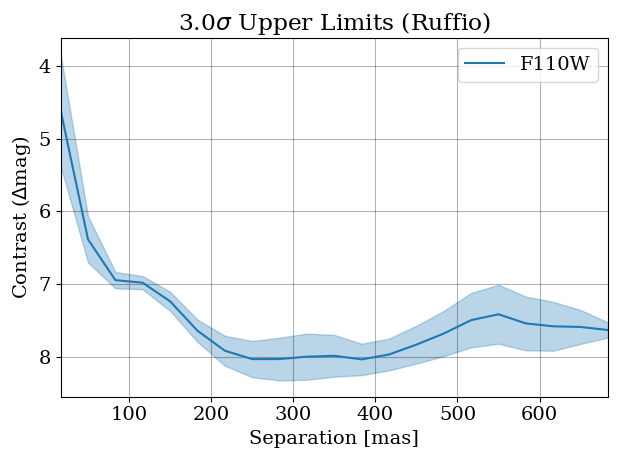

In [47]:
i = 0
rad_width, avg_width, std_width = output["ruffio"]
n_sigma = output["n_sigma"]

dx = 1000 / 60
# plt.title("98% Upper Limits (Ruffio)")
plt.title(rf"{n_sigma}$\sigma$ Upper Limits (Ruffio)")
plt.plot(rad_width * dx, avg_width, label=f"{filt}")
plt.fill_between(
    rad_width * dx,
    avg_width - std_width,
    avg_width + std_width,
    color=f"C{i}",
    alpha=0.3,
)
plt.ylabel("Contrast ($\\Delta$mag)")
plt.xlabel("Separation [mas]")
plt.gca().invert_yaxis()
plt.xlim(
    np.nanmin(rad_width * dx + avg_width * 0.0),
    np.nanmax(rad_width * dx + avg_width * 0.0),
)
plt.grid(color="black", alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()